We start by loading the required libraries.

In [1]:
from functools import partial
import pandas as pd

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median

numpyro.set_host_device_count(4)

Next we define the RBF-kernel $k(\cdot,\cdot)$ given $k(x,y)=\sigma^2 exp\left(-\frac{(x-y)^{2}}{2l^{2}}\right)$

In [14]:
# squared exponential kernel with diagonal noise
def rbf_kernel(X, Z, length, var, noise, jitter=1.0e-6, include_noise=True):

    deltaXsq = jnp.power((X - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)

    if include_noise:
        k += (jitter) * np.eye(X.shape[0])

    return k


In [15]:
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.

    k_pp = rbf_kernel(X=X_test, Z=X_test.T, var=var, length=length, noise=noise)
    k_pX = rbf_kernel(
        X=X_test, Z=X.T, include_noise=False, var=var, length=length, noise=noise
    )
    k_XX = rbf_kernel(X=X, Z=X.T, var=var, length=length, noise=noise)
    K_xx_inv = jnp.linalg.solve(k_XX, jnp.eye(k_XX.shape[0]))
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )

    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise, K


In [32]:
kernel = jax.jit(partial(rbf_kernel, include_noise=True, jitter=1.0e-6))


def GP1(X, y=None):
    N, _ = X.shape

    # Mean-GP
    var_k1 = numpyro.sample("var_k1", dist.HalfNormal(1.0))
    length_k1 = numpyro.sample("length_k1", dist.HalfNormal(1.0))
    noise_k1 = numpyro.sample("noise_k1", dist.HalfNormal(1.0))
    k1 = numpyro.deterministic(
        "k1",
        kernel(
            X=X,
            Z=X.T,
            var=var_k1,
            length=length_k1,
            noise=noise_k1,
            #    include_noise=True,
        ),
    )
    mean = numpyro.sample("mean", dist.MultivariateNormal(jnp.zeros(N), k1))

    scale = numpyro.sample("scale", dist.HalfNormal(1.0))

    assert mean.shape == (N,)
    assert scale.shape == ()
    if y is not None:
        assert y.shape == (N,)

    # Likelihood
    numpyro.sample("y", dist.Normal(loc=mean, scale=scale), obs=y)


In [33]:
df = pd.read_csv("../data/lidar.csv")
x = df.range.values
y = df.logratio.values
x = (x - np.mean(x)) / np.std(x)
y = (y - np.mean(y)) / np.std(y)
X = x[:, np.newaxis]


In [34]:
NUM_WARMUP = 500
NUM_SAMPLES = 1000
NUM_CHAINS = 1
nuts_kernel = NUTS(GP1, init_strategy=init_to_median())
mcmc = MCMC(
    nuts_kernel,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    chain_method="parallel",
)
mcmc.run(X=X, y=y, rng_key=jax.random.PRNGKey(532))
mcmc.print_summary()


sample:  39%|███▊      | 578/1500 [18:14<29:05,  1.89s/it, 1023 steps of size 8.78e-07. acc. prob=0.82] 


KeyboardInterrupt: 

In [ ]:
samples = mcmc.get_samples()


In [10]:
POST_SAMPLES = 100
X_test = np.linspace(1.3 * np.min(x), np.max(x) * 1.3, 500)[:, np.newaxis]
idx = jax.random.randint(
    jax.random.PRNGKey(12), shape=(POST_SAMPLES,), minval=0, maxval=NUM_SAMPLES
)
subsamples = map(
    lambda x: x[idx],
    (samples["var_k1"], samples["length_k1"], samples["noise_k1"]),
)
vmap_args = (jax.random.split(jax.random.PRNGKey(324), POST_SAMPLES),) + tuple(
    subsamples
)
mu, predictions, K1 = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, y, X_test, var, length, noise
    )
)(*vmap_args)
yhat, _, _ = jax.vmap(
    lambda rng_key, var, length, noise: predict(rng_key, X, y, X, var, length, noise)
)(*vmap_args)


In [11]:
predictions.shape

(100, 500)

In [12]:
mean = jnp.mean(mu, axis=0)
yhat = jnp.mean(yhat, axis=0)
hpdi_9 = hpdi(predictions, prob=0.9, axis=0)
y_05 = hpdi_9[0, ...]
y_95 = hpdi_9[1, ...]


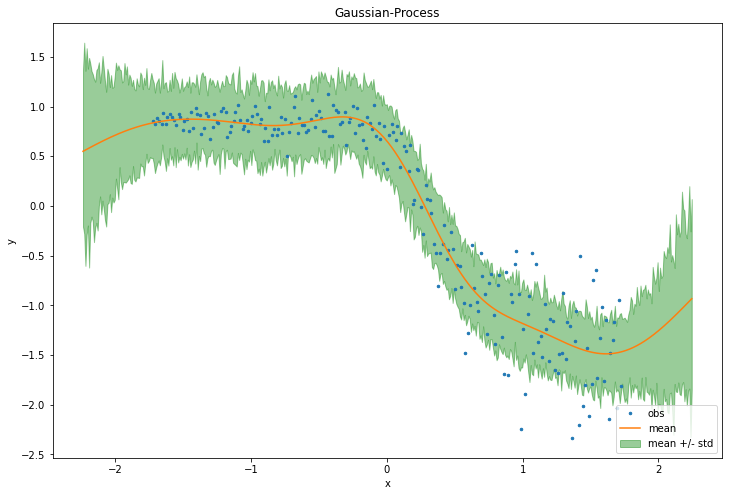

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.plot(X.ravel(), y.ravel(), ".", color="tab:blue", markersize=5, label="obs")
ax.plot(X_test.ravel(), jnp.mean(mu, axis=0), "tab:orange", label="mean")
ax.fill_between(
    X_test.ravel(),
    y_05,
    y_95,
    alpha=0.4,
    color="green",
    label="mean +/- std",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Gaussian-Process")
plt.legend(loc="lower right")


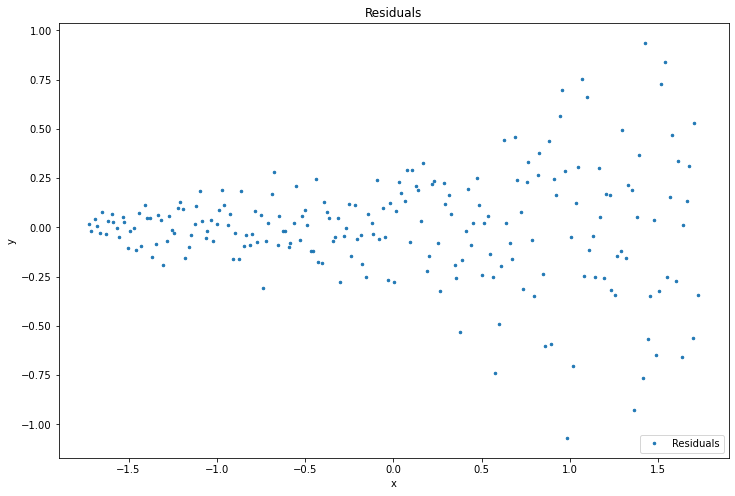

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.plot(X.ravel(), y - yhat, ".", color="tab:blue", markersize=5, label="Residuals")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Residuals")
plt.legend(loc="lower right")


In [51]:
kernel = jax.jit(partial(rbf_kernel, include_noise=True, jitter=1.0e-6))


def GP2(X, y=None):
    N, _ = X.shape

    # Mean-GP
    var_k1 = numpyro.sample("var_k1", dist.LogNormal(0, 1))
    length_k1 = numpyro.sample("length_k1", dist.LogNormal(0, 1))
    noise_k1 = numpyro.sample("noise_k1", dist.LogNormal(0, 1))
    k1 = numpyro.deterministic(
        "k1",
        kernel(
            X=X,
            Z=X.T,
            var=var_k1,
            length=length_k1,
            noise=noise_k1,
        ),
    )
    mean = numpyro.sample("mean", dist.MultivariateNormal(jnp.zeros(N), k1))

    # Variance-GP
    intercept = numpyro.sample("intercept", dist.Normal(0, 1))
    slope = numpyro.sample("slope", dist.Normal(0, 1))
    log_scale = numpyro.deterministic(
        "log_scale", jnp.sum(intercept + slope * X, axis=1)
    )
    scale = numpyro.deterministic("scale", jnp.exp(log_scale))

    assert mean.shape == (N,)
    assert scale.shape == (N,)
    if y is not None:
        assert y.shape == (N,)

    # Likelihood
    numpyro.sample("y", dist.Normal(loc=mean, scale=scale), obs=y)


In [52]:
NUM_WARMUP = 500
NUM_SAMPLES = 1000
NUM_CHAINS = 1

nuts_kernel = NUTS(GP2, init_strategy=init_to_median())
mcmc = MCMC(
    nuts_kernel,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
)
mcmc.run(X=X, y=y, rng_key=jax.random.PRNGKey(532))
mcmc.print_summary()


sample: 100%|██████████| 15000/15000 [07:49<00:00, 31.95it/s, 15 steps of size 2.22e-01. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept     -1.83      0.10     -1.83     -1.99     -1.67    802.42      1.00
  length_k1      0.59      0.08      0.59      0.45      0.73   1483.98      1.00
    mean[0]      0.85      0.03      0.85      0.80      0.91  10841.15      1.00
    mean[1]      0.83      0.04      0.83      0.77      0.88   9147.70      1.00
    mean[2]      0.88      0.04      0.88      0.82      0.94  10352.22      1.00
    mean[3]      0.85      0.04      0.85      0.79      0.91   9465.71      1.00
    mean[4]      0.83      0.04      0.83      0.77      0.89   7840.36      1.00
    mean[5]      0.92      0.04      0.92      0.86      0.98   5979.77      1.00
    mean[6]      0.83      0.04      0.83      0.77      0.89   8111.92      1.00
    mean[7]      0.89      0.04      0.89      0.83      0.95   9789.16      1.00
    mean[8]      0.91      0.04      0.92      0.85      0.98   6375.15      1.00
    mean[9]    

In [53]:
samples = mcmc.get_samples()


In [54]:
POST_SAMPLES = 100
X_test = np.linspace(1.1 * np.min(x), np.max(x) * 1.1, 500)[:, np.newaxis]

idx = jax.random.randint(
    jax.random.PRNGKey(12), shape=(POST_SAMPLES,), minval=0, maxval=NUM_SAMPLES
)
subsamples = map(
    lambda x: x[idx],
    (samples["var_k1"], samples["length_k1"], samples["noise_k1"]),
)
vmap_args = (jax.random.split(jax.random.PRNGKey(324), POST_SAMPLES),) + tuple(
    subsamples
)
mu, predictions, K1 = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, y, X_test, var, length, noise
    )
)(*vmap_args)
yhat, _, _ = jax.vmap(
    lambda rng_key, var, length, noise: predict(rng_key, X, y, X, var, length, noise)
)(*vmap_args)


In [55]:
intercept, slope = map(lambda x: x[idx], (samples["intercept"], samples["slope"]))


In [56]:
mean = jnp.mean(mu, axis=0)
std = jnp.mean(jax.vmap(lambda x: jnp.exp(intercept + slope * x))(X_test), axis=1)
hpdi_9 = hpdi(predictions, prob=0.9, axis=0)
y_05 = hpdi_9[0, ...]
y_95 = hpdi_9[1, ...]


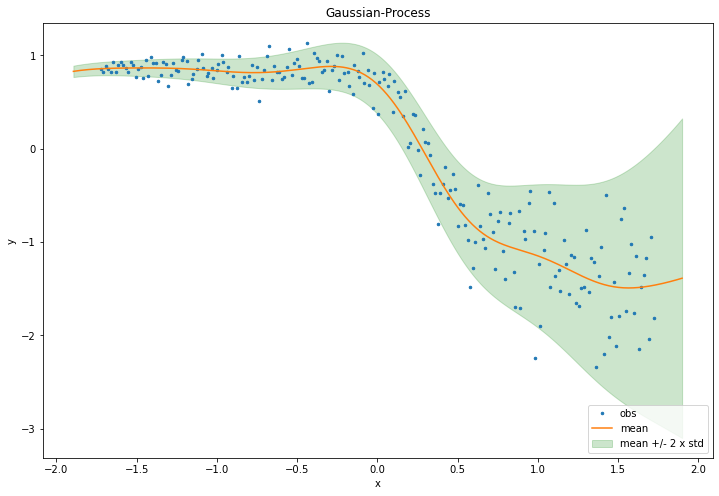

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.plot(X.ravel(), y.ravel(), ".", color="tab:blue", markersize=5, label="obs")
ax.plot(X_test.ravel(), jnp.mean(mu, axis=0), "tab:orange", label="mean")
ax.fill_between(
    X_test.ravel(),
    mean + 2 * std,
    mean - 2 * std,
    alpha=0.2,
    color="green",
    label="mean +/- 2 x std",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Gaussian-Process")
plt.legend(loc="lower right")
